# (Optional) NLP Python Walkthrough

Welcome to this **optional NLP-focused lesson**! Here, we shift from analyzing structured datasets to working with **text data** — the kind of unstructured information often found in misinformation and disinformation campaigns.

We'll use a **COVID-19 Twitter dataset** collected between April and August 2020, a critical time during the pandemic when the spread of misinformation surged online. Tweets from this period offer a unique window into how language, emotion, and repetition shape narratives during a global crisis.

If you're curious about how Python is used to **analyze, clean, and extract meaning from large collections of text**, this lesson is for you. You’ll learn simple methods to process tweets, remove noise, identify patterns, and explore basic sentiment — all essential techniques in **Natural Language Processing (NLP)**.

🔗 **Dataset Source (modified)**: [COVID-19 Twitter Dataset (April–August 2020)](https://www.kaggle.com/datasets/arunavakrchakraborty/covid19-twitter-dataset/data)

---

## 0. Setup & Imports

Before we begin, let’s load the essential libraries for working with and analyzing text data in Python. These tools will help us clean, tokenize, visualize, and extract meaning from the tweets.


In [1]:
# pandas is a powerful library for working with tabular (structured) data
import pandas as pd

# matplotlib lets us create visualizations like bar plots and histograms
import matplotlib.pyplot as plt

# Install the wordcloud package (one-time install)
#!pip install wordcloud

# WordCloud helps us generate word cloud images from text data
from wordcloud import WordCloud

# Install NLTK, a core library for Natural Language Processing
#!pip install nltk

# Import modules for text processing
import nltk
from nltk.corpus import stopwords # List of common words to ignore (e.g., "and", "the", "is")
from nltk.tokenize import word_tokenize # Breaks sentences into individual words

# string is a built-in Python module for working with punctuation
import string

# re is Python’s regular expression module — useful for advanced text cleaning (e.g., removing punctuation, special characters, patterns)
import re

#nltk.download('punkt_tab') # Tokenizer for breaking text into words
#nltk.download('stopwords') # List of stopwords in multiple languages

## 1. Load and Preview the Dataset

Let’s read in the dataset and take a look at the text content we’ll be working with.

In [2]:
# Loads the dataset from a CSV file into a pandas DataFrame (a table-like structure)
df = pd.read_csv("https://raw.githubusercontent.com/BevRice/CMI_Course/refs/heads/main/docs/source/data/2020_Apr_CMI_Course.csv")

In [3]:
# Gives a quick overview of the dataset's structure:
# - number of rows and columns
# - column names
# - data types
# - number of non-missing values

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71951 entries, 0 to 71950
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               71950 non-null  float64
 1   created_at       71950 non-null  object 
 2   source           71938 non-null  object 
 3   original_text    71950 non-null  object 
 4   lang             71950 non-null  object 
 5   favorite_count   71950 non-null  float64
 6   retweet_count    71950 non-null  float64
 7   original_author  71950 non-null  object 
 8   hashtags         14205 non-null  object 
 9   user_mentions    53709 non-null  object 
 10  place            52640 non-null  object 
dtypes: float64(3), object(8)
memory usage: 6.0+ MB


### Dataset Overview (`df.info()`)

The dataset contains **71,951 tweets** with **11 columns**, each representing metadata about the tweets. Here's a quick summary of what `df.info()` tells us:

- **Row count**: We have 71,951 entries (rows), indexed from 0 to 71,950.
- **Data types**:
  - Most columns are stored as `object` (typically strings or mixed types).
  - Three columns (`id`, `favorite_count`, `retweet_count`) are numeric (`float64`).
- **Missing values**:
  - `hashtags`, `user_mentions`, and `place` have a significant number of missing values — this is common in Twitter data where not every tweet includes a hashtag, mention, or location.
  - `source` and `id` have a very small number of missing values (likely ignorable or fixable).
- **Text content**:
  - The main tweet content is in the `original_text` column, which we’ll focus on for NLP tasks.
- **Engagement metrics**:
  - We have `favorite_count` (likes) and `retweet_count`, which will help us understand how sentiment or wording may relate to tweet visibility.

Understanding the structure and completeness of the dataset helps us plan our cleaning and analysis steps — especially which columns to focus on and which to treat with caution due to missing data.


In [4]:
# Generates summary statistics for numeric columns (e.g., likes, retweets if present)
# Includes count, mean, min, max, etc.

df.describe()

,id,favorite_count,retweet_count
count,7.195000e+04,71950.000000,71950.000000
mean,1.260083e+18,0.211022,1960.392648
std,5.398419e+15,5.981731,10304.309143
min,1.250000e+18,0.000000,0.000000
25%,1.260000e+18,0.000000,1.000000
50%,1.260000e+18,0.000000,17.000000
75%,1.260000e+18,0.000000,304.000000
max,1.270000e+18,1166.000000,399220.000000


### Summary Statistics (`df.describe()`)

This table shows basic statistics for the dataset’s **numeric columns** — helpful for understanding the distribution of tweet engagement and structure:

#### `id`
- These are large numeric identifiers for each tweet (likely encoded as `float64` here).
- The range is very tight, indicating that most tweets were collected from a similar time period.
- We typically won’t analyze this column, but it's useful as a unique identifier.

#### `favorite_count` (likes)
- **Mean (avg)**: ~0.21 likes per tweet — this is very low.
- **Median (50%)**: 0.0 — most tweets weren’t liked at all.
- **Max**: 1,166 likes on a single tweet.
- The distribution is **heavily skewed**, with a few popular tweets receiving most of the engagement.

#### `retweet_count`
- **Mean**: ~1,960 retweets per tweet — seems high, but:
- **Median (50%)**: only 17 — again suggesting a **long tail** where a few viral tweets account for most of the retweets.
- **Max**: one tweet received nearly **400,000 retweets** — likely a standout viral message.

#### Takeaways
- Most tweets had **low engagement**, which is typical in large social media datasets.
- A few tweets had **extremely high reach**, which can dramatically influence averages.
- This distribution (lots of low values, a few very high ones) is a common trait in social media data — and important to remember when analyzing or visualizing trends.


In [5]:
# Randomly shows 5 rows from the dataset
# Helpful to get a feel for what the actual tweets look like

df.sample(5)

,id,created_at,source,original_text,lang,favorite_count,retweet_count,original_author,hashtags,user_mentions,place
65258,1.270000e+18,2020-06-06,"<a href=""http://twitter.com/download/android"" ...",Ontario covid-19 cases by reported date (Publi...,en,0.0,66.0,Milhouse_Van_Ho,"covid19ontario, covidontario",NaN,Springfield
57014,1.270000e+18,2020-06-01,"<a href=""http://twitter.com/download/iphone"" r...",@TheHannahRay @KOINNews Fucking protesters tou...,en,0.0,20741.0,TheOGGeno,NaN,"TheHannahRay, KOINNews","Portland, OR"
35308,1.270000e+18,2020-06-14,"<a href=""http://twitter.com/download/android"" ...","RT @channelstv: 48 COVID-19 Patients Recover, ...",en,0.0,8586.0,ahmadbadaru,NaN,channelstv,Around the globe 🌍
10908,1.260000e+18,2020-05-11,"<a href=""http://twitter.com/download/iphone"" r...",China berated New Zealand for its support for ...,en,0.0,363.0,nathanattrill,NaN,NaN,Canberra
13283,1.260000e+18,2020-05-01,"<a href=""http://twitter.com/download/android"" ...",RT @JamesrossrJames: stats...the great trump C...,en,0.0,27.0,krollteri,NaN,JamesrossrJames,NaN


We will specifically be working with the *original_text* column

Before we start cleaning the tweets, let’s take a look at the raw text. By default, long strings may get truncated in pandas, so we’ll update the display settings to show the full content of each tweet.

In [6]:
# Ensure full tweet text is displayed (no truncation)
pd.set_option('display.max_colwidth', None)

# Preview the first 10 tweets from the 'original_text' column
df[['original_text']].head(10) 

,original_text
0,RT @MasiTweets: Yesterday we held our event and thanks to Dr. Dean Allen it was a success! Head over to our blog&gt;&gt; https://t.co/2wjDVxjT0V…
1,"RT @NEJM: In this audio interview, the editors are joined by Michele Evans, MD, of the National Institutes of Health to discuss a new study…"
2,. @davidtrnr1 Frankie’s missed out on GCSE’s thanks to Covid-19 but fortunately got the leavers sweatshirt 😝 https://t.co/IznsrUmbj6
3,"RT @KoochieKinte: LADIES: Would you rather test positive for covid-19 and be put on a ventilator, but you SURVIVE, or test positive for a p…"
4,"#CoronaVirusSA, think COVID-19, wash your hands, keep your distance &amp; contact 021 928 4102 (Western Cape) if sympto… https://t.co/hvEUVqzuhd"
5,RT @IamShaistaLodhi: Foot Shake greeting with @fahadmustafa26 on #JeetoPakistanLeague courtesy Covid 19 #JeetoPakistan #ShaistaLodhi #Fahad…
6,"RT @Bud_Doggin: Where is William Barr and the DOJ??? @realDonaldTrump \n\nAs of Saturday, the state which has recorded 104 COVID-19 deaths ou…"
7,"RT @BJP4Karnataka: Among the top cities in India, Namma Bengaluru has managed the #COVID__19 pandemic more effectively.\n\nA BIG THANKS to CM…"
8,RT @Documentedny: More than 50 migrant workers at a large produce farm in NJ tested positive for COVID-19\n\nVia @njspotlight\n\nhttps://t.co/V…
9,RT @Ian56789: UK's Chief Scientific Advisor Patrick Vallance confirms the death statistics for #Covid19 are being manipulated to increase t…


---

## 2. Text Preprocessing

Before we analyze the tweets, we need to clean the text. This includes:

- Lowercasing  
- Removing punctuation  
- Removing stopwords (e.g., “the”, “and”, “is”)  
- Tokenizing into individual words

To keep the original tweets intact, we’ll create a separate column called `clean_text` that we’ll use for preprocessing. This way, we can always compare the cleaned version to the original if needed.

In [7]:
# Create a copy of the original text for cleaning
df['clean_text'] = df['original_text'].copy()

# Display both the original and clean versions side by side
# At this point, they should be identical since no cleaning has been applied yet
df[['original_text', 'clean_text']].head()

,original_text,clean_text
0,RT @MasiTweets: Yesterday we held our event and thanks to Dr. Dean Allen it was a success! Head over to our blog&gt;&gt; https://t.co/2wjDVxjT0V…,RT @MasiTweets: Yesterday we held our event and thanks to Dr. Dean Allen it was a success! Head over to our blog&gt;&gt; https://t.co/2wjDVxjT0V…
1,"RT @NEJM: In this audio interview, the editors are joined by Michele Evans, MD, of the National Institutes of Health to discuss a new study…","RT @NEJM: In this audio interview, the editors are joined by Michele Evans, MD, of the National Institutes of Health to discuss a new study…"
2,. @davidtrnr1 Frankie’s missed out on GCSE’s thanks to Covid-19 but fortunately got the leavers sweatshirt 😝 https://t.co/IznsrUmbj6,. @davidtrnr1 Frankie’s missed out on GCSE’s thanks to Covid-19 but fortunately got the leavers sweatshirt 😝 https://t.co/IznsrUmbj6
3,"RT @KoochieKinte: LADIES: Would you rather test positive for covid-19 and be put on a ventilator, but you SURVIVE, or test positive for a p…","RT @KoochieKinte: LADIES: Would you rather test positive for covid-19 and be put on a ventilator, but you SURVIVE, or test positive for a p…"
4,"#CoronaVirusSA, think COVID-19, wash your hands, keep your distance &amp; contact 021 928 4102 (Western Cape) if sympto… https://t.co/hvEUVqzuhd","#CoronaVirusSA, think COVID-19, wash your hands, keep your distance &amp; contact 021 928 4102 (Western Cape) if sympto… https://t.co/hvEUVqzuhd"


The first step in cleaning our text is to standardize capitalization. By converting everything to lowercase, we make sure that words like "COVID", "Covid", and "covid" are treated the same during analysis.

In [8]:
# Convert all text in the 'clean_text' column to lowercase
# This helps standardize the text (e.g., "Covid" and "covid" will be treated the same)
df['clean_text'] = df['clean_text'].str.lower()

# Display the original and lowercased versions side by side
df[['original_text', 'clean_text']].head()

,original_text,clean_text
0,RT @MasiTweets: Yesterday we held our event and thanks to Dr. Dean Allen it was a success! Head over to our blog&gt;&gt; https://t.co/2wjDVxjT0V…,rt @masitweets: yesterday we held our event and thanks to dr. dean allen it was a success! head over to our blog&gt;&gt; https://t.co/2wjdvxjt0v…
1,"RT @NEJM: In this audio interview, the editors are joined by Michele Evans, MD, of the National Institutes of Health to discuss a new study…","rt @nejm: in this audio interview, the editors are joined by michele evans, md, of the national institutes of health to discuss a new study…"
2,. @davidtrnr1 Frankie’s missed out on GCSE’s thanks to Covid-19 but fortunately got the leavers sweatshirt 😝 https://t.co/IznsrUmbj6,. @davidtrnr1 frankie’s missed out on gcse’s thanks to covid-19 but fortunately got the leavers sweatshirt 😝 https://t.co/iznsrumbj6
3,"RT @KoochieKinte: LADIES: Would you rather test positive for covid-19 and be put on a ventilator, but you SURVIVE, or test positive for a p…","rt @koochiekinte: ladies: would you rather test positive for covid-19 and be put on a ventilator, but you survive, or test positive for a p…"
4,"#CoronaVirusSA, think COVID-19, wash your hands, keep your distance &amp; contact 021 928 4102 (Western Cape) if sympto… https://t.co/hvEUVqzuhd","#coronavirussa, think covid-19, wash your hands, keep your distance &amp; contact 021 928 4102 (western cape) if sympto… https://t.co/hveuvqzuhd"


Next, we’ll remove punctuation from the tweets. This helps simplify the text and avoids treating words like "virus" and "virus!" as different tokens. 
We define a function using Python’s `string.punctuation`, then apply it to the `clean_text` column.

In [9]:
# Define a function to remove punctuation from text
def remove_punctuation(text):
    # Keep only letters, numbers, and spaces
    return re.sub(r'[^\w\s]', '', text)


# Apply the function to clean punctuation from tweets
df['clean_text'] = df['clean_text'].astype(str).apply(remove_punctuation)

# Compare the original and punctuation-free text
df[['original_text', 'clean_text']].head()

,original_text,clean_text
0,RT @MasiTweets: Yesterday we held our event and thanks to Dr. Dean Allen it was a success! Head over to our blog&gt;&gt; https://t.co/2wjDVxjT0V…,rt masitweets yesterday we held our event and thanks to dr dean allen it was a success head over to our bloggtgt httpstco2wjdvxjt0v
1,"RT @NEJM: In this audio interview, the editors are joined by Michele Evans, MD, of the National Institutes of Health to discuss a new study…",rt nejm in this audio interview the editors are joined by michele evans md of the national institutes of health to discuss a new study
2,. @davidtrnr1 Frankie’s missed out on GCSE’s thanks to Covid-19 but fortunately got the leavers sweatshirt 😝 https://t.co/IznsrUmbj6,davidtrnr1 frankies missed out on gcses thanks to covid19 but fortunately got the leavers sweatshirt httpstcoiznsrumbj6
3,"RT @KoochieKinte: LADIES: Would you rather test positive for covid-19 and be put on a ventilator, but you SURVIVE, or test positive for a p…",rt koochiekinte ladies would you rather test positive for covid19 and be put on a ventilator but you survive or test positive for a p
4,"#CoronaVirusSA, think COVID-19, wash your hands, keep your distance &amp; contact 021 928 4102 (Western Cape) if sympto… https://t.co/hvEUVqzuhd",coronavirussa think covid19 wash your hands keep your distance amp contact 021 928 4102 western cape if sympto httpstcohveuvqzuhd


Stopwords are common words (like “the”, “is”, “in”) that usually don’t add meaningful information in text analysis. 

By removing them, we can focus on the keywords that actually carry useful content.

Here, we tokenize each tweet, filter out the stopwords, and then rejoin the cleaned words into a single string.

In [10]:
# Load the list of English stopwords (common words like "the", "is", "and")
stop_words = set(stopwords.words('english'))

# Define a function to remove stopwords from text
def remove_stopwords(text):
    tokens = word_tokenize(text)  # Break text into individual words (tokens)
    filtered = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered)  # Rejoin tokens into a cleaned string

# Apply the stopword removal function to the 'clean_text' column
df['clean_text'] = df['clean_text'].astype(str).apply(remove_stopwords)

# Compare the original and cleaned (stopword-free) text
df[['original_text', 'clean_text']].head()

,original_text,clean_text
0,RT @MasiTweets: Yesterday we held our event and thanks to Dr. Dean Allen it was a success! Head over to our blog&gt;&gt; https://t.co/2wjDVxjT0V…,rt masitweets yesterday held event thanks dr dean allen success head bloggtgt httpstco2wjdvxjt0v
1,"RT @NEJM: In this audio interview, the editors are joined by Michele Evans, MD, of the National Institutes of Health to discuss a new study…",rt nejm audio interview editors joined michele evans md national institutes health discuss new study
2,. @davidtrnr1 Frankie’s missed out on GCSE’s thanks to Covid-19 but fortunately got the leavers sweatshirt 😝 https://t.co/IznsrUmbj6,davidtrnr1 frankies missed gcses thanks covid19 fortunately got leavers sweatshirt httpstcoiznsrumbj6
3,"RT @KoochieKinte: LADIES: Would you rather test positive for covid-19 and be put on a ventilator, but you SURVIVE, or test positive for a p…",rt koochiekinte ladies would rather test positive covid19 put ventilator survive test positive p
4,"#CoronaVirusSA, think COVID-19, wash your hands, keep your distance &amp; contact 021 928 4102 (Western Cape) if sympto… https://t.co/hvEUVqzuhd",coronavirussa think covid19 wash hands keep distance amp contact 021 928 4102 western cape sympto httpstcohveuvqzuhd


Tokenization is the process of splitting text into individual words (called "tokens"). 

This is a foundational step in NLP that allows us to analyze word frequency, build word clouds, and perform sentiment analysis.

Here, we tokenize the cleaned text and store the result in a new column.

In [11]:
# Tokenize the cleaned text into individual words (tokens)
df['tokens'] = df['clean_text'].astype(str).apply(word_tokenize)

# View the original, cleaned, and tokenized versions side by side
df[['original_text', 'clean_text', 'tokens']].head()

,original_text,clean_text,tokens
0,RT @MasiTweets: Yesterday we held our event and thanks to Dr. Dean Allen it was a success! Head over to our blog&gt;&gt; https://t.co/2wjDVxjT0V…,rt masitweets yesterday held event thanks dr dean allen success head bloggtgt httpstco2wjdvxjt0v,"[rt, masitweets, yesterday, held, event, thanks, dr, dean, allen, success, head, bloggtgt, httpstco2wjdvxjt0v]"
1,"RT @NEJM: In this audio interview, the editors are joined by Michele Evans, MD, of the National Institutes of Health to discuss a new study…",rt nejm audio interview editors joined michele evans md national institutes health discuss new study,"[rt, nejm, audio, interview, editors, joined, michele, evans, md, national, institutes, health, discuss, new, study]"
2,. @davidtrnr1 Frankie’s missed out on GCSE’s thanks to Covid-19 but fortunately got the leavers sweatshirt 😝 https://t.co/IznsrUmbj6,davidtrnr1 frankies missed gcses thanks covid19 fortunately got leavers sweatshirt httpstcoiznsrumbj6,"[davidtrnr1, frankies, missed, gcses, thanks, covid19, fortunately, got, leavers, sweatshirt, httpstcoiznsrumbj6]"
3,"RT @KoochieKinte: LADIES: Would you rather test positive for covid-19 and be put on a ventilator, but you SURVIVE, or test positive for a p…",rt koochiekinte ladies would rather test positive covid19 put ventilator survive test positive p,"[rt, koochiekinte, ladies, would, rather, test, positive, covid19, put, ventilator, survive, test, positive, p]"
4,"#CoronaVirusSA, think COVID-19, wash your hands, keep your distance &amp; contact 021 928 4102 (Western Cape) if sympto… https://t.co/hvEUVqzuhd",coronavirussa think covid19 wash hands keep distance amp contact 021 928 4102 western cape sympto httpstcohveuvqzuhd,"[coronavirussa, think, covid19, wash, hands, keep, distance, amp, contact, 021, 928, 4102, western, cape, sympto, httpstcohveuvqzuhd]"


In [12]:
# Remove extra whitespace (spaces, tabs, line breaks)
df['clean_text'] = df['clean_text'].str.strip().replace(r'\s+', ' ', regex=True)

---

## 3. Word Frequency Distribution

Now that we’ve cleaned and tokenized the tweets, let’s analyze which words appear most frequently in the dataset.

This step gives us a quick sense of the dominant topics, phrases, or themes — a common practice in exploratory NLP.

We use Python’s `Counter` to count how often each word appears across all tweets. 
Then we select the top 20 and visualize them using a bar chart. 
This gives us an at-a-glance view of which words dominate the conversation during this time period.

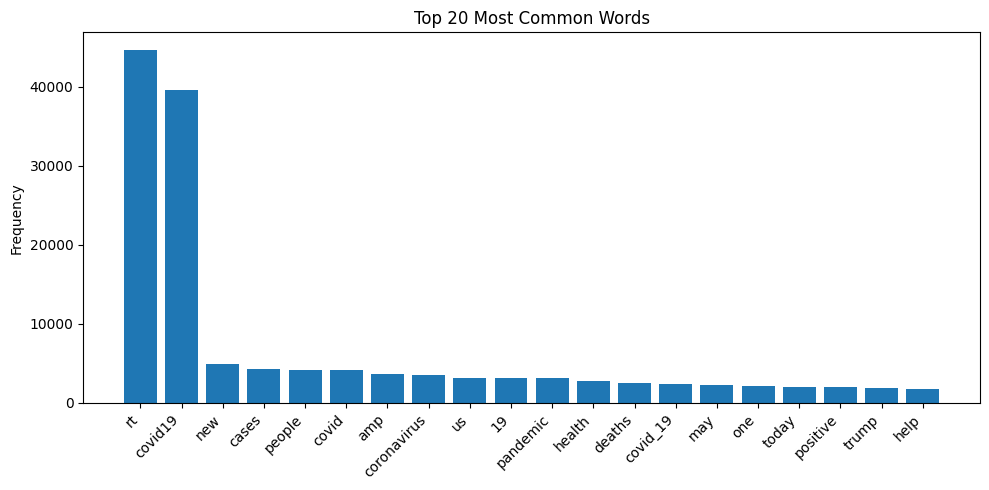

In [13]:
from collections import Counter

# Flatten the list of all tokens across all tweets into a single list of words
all_words = [word for tokens in df['tokens'] for word in tokens]

# Count how often each word appears using Python's built-in Counter
word_freq = Counter(all_words)

# Get the 20 most common words and their frequencies
common_words = word_freq.most_common(20)

# Prepare data for plotting
words, counts = zip(*common_words)
plt.figure(figsize=(10, 5))
plt.bar(words, counts)
plt.xticks(rotation=45, ha='right')
plt.title("Top 20 Most Common Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

### Interpreting the Top 20 Most Common Words

This bar chart shows the most frequent words that appeared in tweets from April–August 2020, after text cleaning and stopword removal.

#### Observations:
- **"covid19"** dominates the conversation — it appears far more frequently than any other word.
- Other highly frequent words include:
  - **Health-related terms**: `cases`, `people`, `covid`, `coronavirus`, `pandemic`, `deaths`, `health`
  - **Time and context words**: `new`, `today`, `may`
  - **Entities and influence**: `trump`, `us`
  - **Tone indicators**: `positive`, `help`

#### Interpretation:
- The vocabulary reflects the **core themes of the early pandemic**: tracking the virus, public health, government action, and the social or emotional tone of the moment.
- This kind of frequency analysis gives a **quick snapshot** of dominant topics, but lacks nuance — we’ll use sentiment and deeper analysis to explore emotional content and bias next.


In [14]:
# Convert counter output to a DataFrame for easier viewing and sorting
freq_df = pd.DataFrame(word_freq.items(), columns=['word', 'frequency'])
freq_df.sort_values(by='frequency', ascending=False).head(10)

,word,frequency
0,rt,44671
31,covid19,39585
25,new,4949
175,cases,4244
440,people,4137
69,covid,4114
53,amp,3705
252,coronavirus,3555
159,us,3210
70,19,3168


After reviewing the most common words, we noticed that some common Twitter-specific tokens (like “rt”, “amp”, and “https”) still appear in the dataset. These don’t carry much meaning and can clutter our analysis.

We add these to a custom stopword list, then reapply the stopword removal and tokenization steps.

In [15]:
# Add additional custom stopwords specific to this dataset
# These include common Twitter artifacts and low-value filler words

custom_stopwords = {
    'rt', 'https', 'http', 'amp', 'co', 't', 'c', 'www',
    'via', 'get', 'could', 'still', 'go', 'let', 'b',
}

# Update the stop_words set with the custom stopwords
stop_words.update(custom_stopwords)

# Reapply the stopword removal to the clean_text column
df['clean_text'] = df['clean_text'].astype(str).apply(remove_stopwords)

# Retokenize the cleaned text
df['tokens'] = df['clean_text'].astype(str).apply(word_tokenize)
all_words = [word for tokens in df['tokens'] for word in tokens]

# View the original, cleaned, and tokenized text side by side
df[['original_text', 'clean_text', 'tokens']].head()

,original_text,clean_text,tokens
0,RT @MasiTweets: Yesterday we held our event and thanks to Dr. Dean Allen it was a success! Head over to our blog&gt;&gt; https://t.co/2wjDVxjT0V…,masitweets yesterday held event thanks dr dean allen success head bloggtgt httpstco2wjdvxjt0v,"[masitweets, yesterday, held, event, thanks, dr, dean, allen, success, head, bloggtgt, httpstco2wjdvxjt0v]"
1,"RT @NEJM: In this audio interview, the editors are joined by Michele Evans, MD, of the National Institutes of Health to discuss a new study…",nejm audio interview editors joined michele evans md national institutes health discuss new study,"[nejm, audio, interview, editors, joined, michele, evans, md, national, institutes, health, discuss, new, study]"
2,. @davidtrnr1 Frankie’s missed out on GCSE’s thanks to Covid-19 but fortunately got the leavers sweatshirt 😝 https://t.co/IznsrUmbj6,davidtrnr1 frankies missed gcses thanks covid19 fortunately got leavers sweatshirt httpstcoiznsrumbj6,"[davidtrnr1, frankies, missed, gcses, thanks, covid19, fortunately, got, leavers, sweatshirt, httpstcoiznsrumbj6]"
3,"RT @KoochieKinte: LADIES: Would you rather test positive for covid-19 and be put on a ventilator, but you SURVIVE, or test positive for a p…",koochiekinte ladies would rather test positive covid19 put ventilator survive test positive p,"[koochiekinte, ladies, would, rather, test, positive, covid19, put, ventilator, survive, test, positive, p]"
4,"#CoronaVirusSA, think COVID-19, wash your hands, keep your distance &amp; contact 021 928 4102 (Western Cape) if sympto… https://t.co/hvEUVqzuhd",coronavirussa think covid19 wash hands keep distance contact 021 928 4102 western cape sympto httpstcohveuvqzuhd,"[coronavirussa, think, covid19, wash, hands, keep, distance, contact, 021, 928, 4102, western, cape, sympto, httpstcohveuvqzuhd]"


---

## 4. Word Cloud

Below are two versions of a word cloud generated from the tweet data. Word clouds provide a quick, intuitive way to visualize the most frequently used words — the **larger the word, the more often it appears** in the dataset.

---

#### Word Cloud (Default: Joined Tokens)

The first word cloud is generated by passing a large string of all tweet text into the word cloud generator. While easy to implement, this method:

- May preserve **joined terms** like `"covid19"` or `"coronavirus pandemic"` if punctuation wasn't fully removed
- Treats the entire text as a single body, without counting true word frequency

This can result in some merged or repeated terms and potentially misrepresent the most important individual words.

---

#### Word Cloud (Based on Individual Token Frequency)

The second version is built from a **frequency dictionary of individual tokens** (words), using `generate_from_frequencies()`.

- This approach respects actual word-level counts
- More accurate for NLP tasks like keyword analysis
- Less likely to be skewed by formatting artifacts


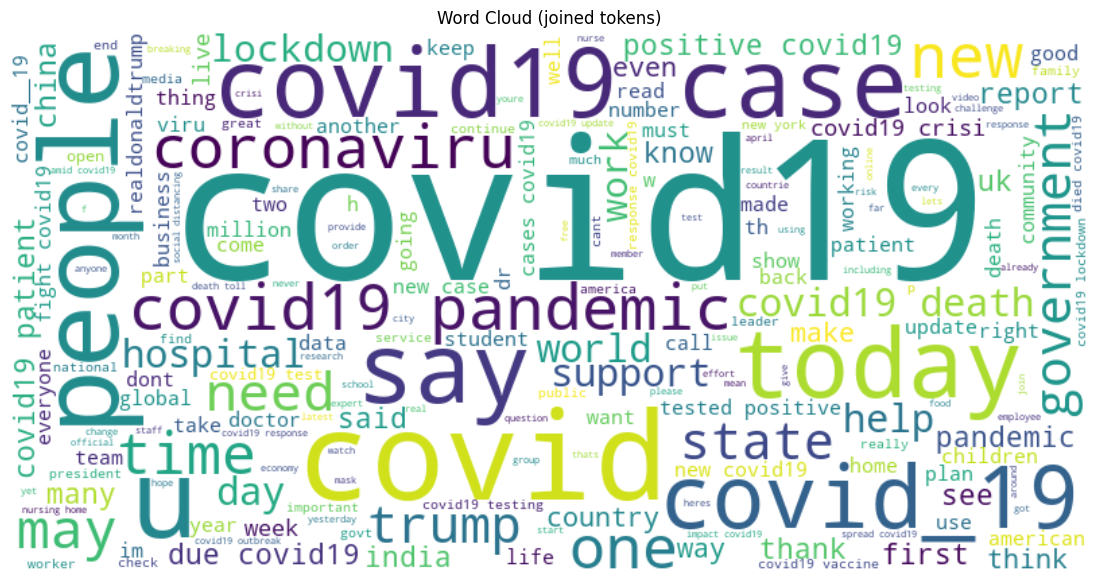

In [16]:
# Generate default word cloud (may show phrases or joined terms)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud (joined tokens)")
plt.show()

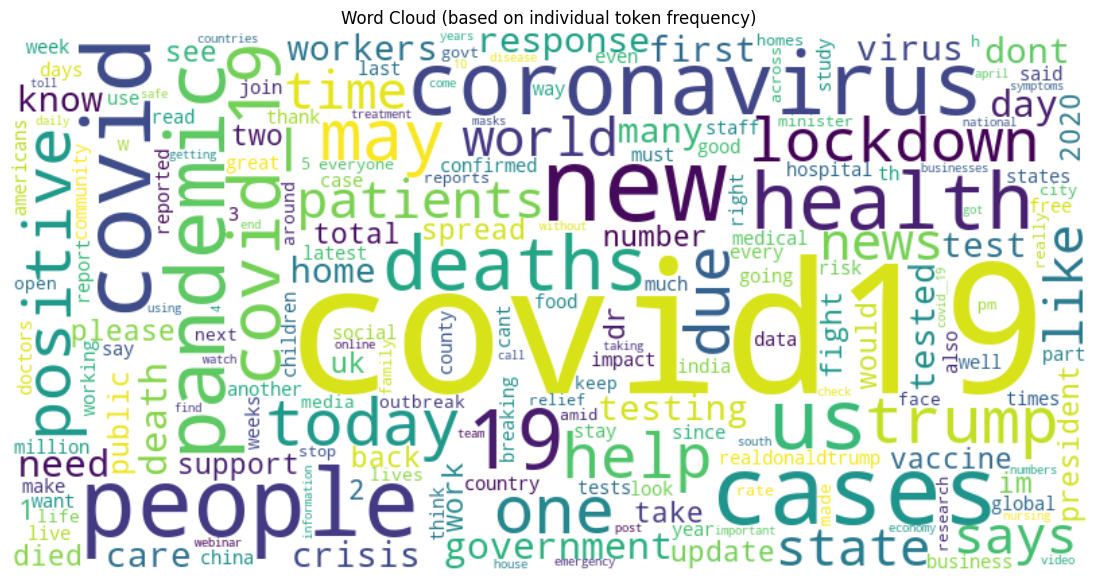

In [17]:
# Generate a word cloud using actual token frequencies
from collections import Counter

# Count word frequencies
token_freq = Counter(all_words)

# Pass the frequency dictionary directly to WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(token_freq)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud (based on individual token frequency)")
plt.show()


### 🔍 Key Takeaways:

- Both clouds highlight similar core themes: **covid19**, **cases**, **pandemic**, **people**, **government**, **health**, **deaths**
- The token-based cloud gives you a **cleaner and truer picture** of what terms dominate the discourse
- Always be mindful of how the input structure affects your visualization output

For real analysis, we recommend using **token frequency-based clouds** — especially after proper cleaning and stopword removal.

---

## 5. Basic Sentiment Analysis

Now that we've cleaned and tokenized the tweets, let’s explore the **emotional tone** of the text using basic sentiment analysis.

We'll use [TextBlob](https://textblob.readthedocs.io/en/dev/) — a simple, beginner-friendly NLP library that assigns a **polarity score** between -1 (very negative) and +1 (very positive) to each tweet.


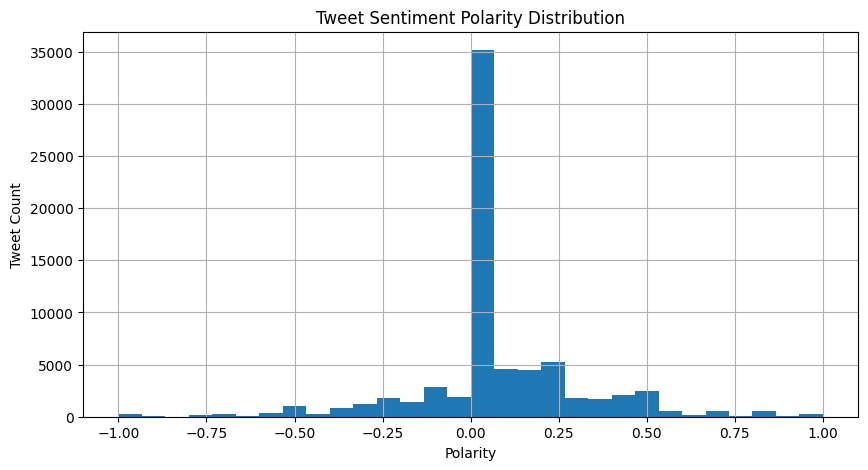

In [18]:
# Install TextBlob (run this once in your notebook environment)
#!pip install textblob

# Import TextBlob for basic sentiment analysis
from textblob import TextBlob

# Apply TextBlob to calculate sentiment polarity for each tweet
# Polarity ranges from -1 (negative) to +1 (positive)
df['polarity'] = df['clean_text'].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)

# Plot the distribution of sentiment polarity scores
df['polarity'].hist(bins=30, figsize=(10, 5))
plt.title("Tweet Sentiment Polarity Distribution")
plt.xlabel("Polarity")
plt.ylabel("Tweet Count")
plt.show()


#### What We See:
- A sharp spike at **0**, indicating a large number of tweets with **neutral sentiment** — possibly factual updates or minimal emotional content.
- A long tail toward **positive values**, with many tweets clustering between **0.1 and 0.5**, suggesting a general lean toward **mild positivity**.
- A smaller but noticeable number of tweets have **negative sentiment** (left side of the chart), with some scoring below -0.5.

---

#### Interpretation:
- Tweets during this period (April–August 2020) likely included a mix of:
  - **Factual news and public updates** (neutral tone)
  - **Expressions of support, resilience, or solidarity** (mildly positive)
  - **Frustration, fear, or criticism** (negative)
- The prevalence of neutral sentiment is common in large-scale social media datasets — especially when covering news, public health, or event reporting.

---

In [19]:
# Print polarity score column alongside text
df[['original_text', 'clean_text', 'tokens', 'polarity']].head()

,original_text,clean_text,tokens,polarity
0,RT @MasiTweets: Yesterday we held our event and thanks to Dr. Dean Allen it was a success! Head over to our blog&gt;&gt; https://t.co/2wjDVxjT0V…,masitweets yesterday held event thanks dr dean allen success head bloggtgt httpstco2wjdvxjt0v,"[masitweets, yesterday, held, event, thanks, dr, dean, allen, success, head, bloggtgt, httpstco2wjdvxjt0v]",0.250000
1,"RT @NEJM: In this audio interview, the editors are joined by Michele Evans, MD, of the National Institutes of Health to discuss a new study…",nejm audio interview editors joined michele evans md national institutes health discuss new study,"[nejm, audio, interview, editors, joined, michele, evans, md, national, institutes, health, discuss, new, study]",0.136364
2,. @davidtrnr1 Frankie’s missed out on GCSE’s thanks to Covid-19 but fortunately got the leavers sweatshirt 😝 https://t.co/IznsrUmbj6,davidtrnr1 frankies missed gcses thanks covid19 fortunately got leavers sweatshirt httpstcoiznsrumbj6,"[davidtrnr1, frankies, missed, gcses, thanks, covid19, fortunately, got, leavers, sweatshirt, httpstcoiznsrumbj6]",0.300000
3,"RT @KoochieKinte: LADIES: Would you rather test positive for covid-19 and be put on a ventilator, but you SURVIVE, or test positive for a p…",koochiekinte ladies would rather test positive covid19 put ventilator survive test positive p,"[koochiekinte, ladies, would, rather, test, positive, covid19, put, ventilator, survive, test, positive, p]",0.227273
4,"#CoronaVirusSA, think COVID-19, wash your hands, keep your distance &amp; contact 021 928 4102 (Western Cape) if sympto… https://t.co/hvEUVqzuhd",coronavirussa think covid19 wash hands keep distance contact 021 928 4102 western cape sympto httpstcohveuvqzuhd,"[coronavirussa, think, covid19, wash, hands, keep, distance, contact, 021, 928, 4102, western, cape, sympto, httpstcohveuvqzuhd]",0.000000


In [20]:
# Filter by polarity score == -1 (very negative)
# Print first 5 instances
df[df['polarity']==-1][['original_text', 'polarity']].head()

,original_text,polarity
145,The worst thing about this is the media silence on government failings. No one will be held accountable for thousan… https://t.co/2BgwM6XaiT,-1.0
794,"RT @60Mins: Five weeks ago, Adrian did catch COVID-19. He doesn’t know where or how he contracted the virus that he says was the worst expe…",-1.0
886,@realDonaldTrump Everyone likes to have a look at a comedian once in a while and things are rather boring 🥱 in this COVID-19 era 🙂,-1.0
907,RT @MaliNye: If you want to know what the world thinks of our government this makes grim and embarrassing reading. ‘Complacent ’ UK draw…,-1.0
1125,"RT @PTIofficial: Removing the “dependency syndrome” bit by bit. #Covid_19 situation is grim, but as PM Khan says, every adversity must be c…",-1.0


✅ What is Subjectivity?

    Polarity = How positive or negative the text is (from -1 to +1)

    Subjectivity = How subjective or opinionated the text is (from 0 to 1)

        0 = very objective (factual)

        1 = very subjective (personal opinion, emotion, speculation)

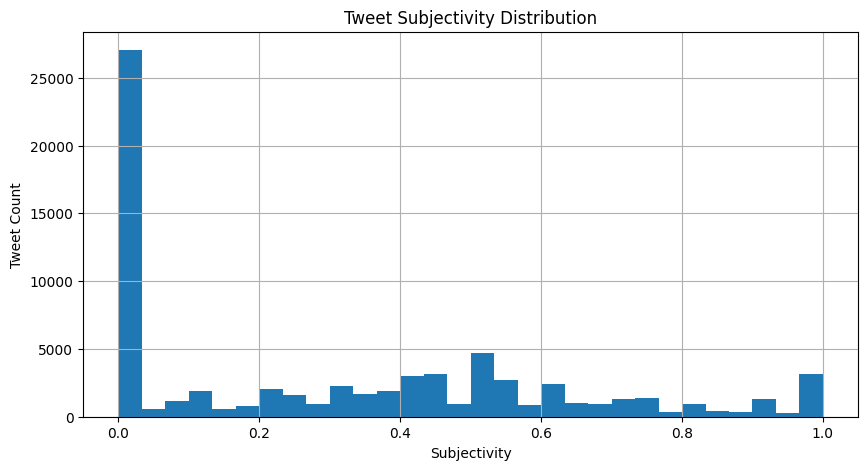

In [21]:
# Apply TextBlob to calculate subjectivity
df['subjectivity'] = df['clean_text'].astype(str).apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Plot the distribution of subjectivity
df['subjectivity'].hist(bins=30, figsize=(10, 5))
plt.title("Tweet Subjectivity Distribution")
plt.xlabel("Subjectivity")
plt.ylabel("Tweet Count")
plt.show()

#### What We See:
- A large spike at or near **0.0**, indicating many tweets are **highly objective** — likely news headlines, factual statements, or automated updates.
- A more even spread from **0.1 to 0.9**, with peaks around **0.4–0.6**, suggesting a mix of opinions, reactions, and commentary.
- A smaller cluster of highly **subjective tweets** near **1.0**, which likely contain emotional or personal expressions (e.g., fears, praise, outrage, etc.).

---

#### Interpretation:
- The spike in objectivity is consistent with tweets that share public health information, statistics, or news headlines.
- The broader spread across the rest of the distribution reflects how social media platforms like Twitter blend factual content with emotional or biased reactions.
- Subjectivity analysis helps identify tweets that are **more opinion-driven**, which may be more prone to spreading **misinformation, bias, or personal narratives**.

---

This layer of analysis is particularly useful for misinformation research: highly subjective content may signal opinion-based claims, while objective-sounding tweets could be used to mimic credibility.


In [22]:
# Print polarity & subjectivity score column alongside text
df[['original_text', 'clean_text', 'tokens', 'polarity', 'subjectivity']].head()

,original_text,clean_text,tokens,polarity,subjectivity
0,RT @MasiTweets: Yesterday we held our event and thanks to Dr. Dean Allen it was a success! Head over to our blog&gt;&gt; https://t.co/2wjDVxjT0V…,masitweets yesterday held event thanks dr dean allen success head bloggtgt httpstco2wjdvxjt0v,"[masitweets, yesterday, held, event, thanks, dr, dean, allen, success, head, bloggtgt, httpstco2wjdvxjt0v]",0.250000,0.100000
1,"RT @NEJM: In this audio interview, the editors are joined by Michele Evans, MD, of the National Institutes of Health to discuss a new study…",nejm audio interview editors joined michele evans md national institutes health discuss new study,"[nejm, audio, interview, editors, joined, michele, evans, md, national, institutes, health, discuss, new, study]",0.136364,0.454545
2,. @davidtrnr1 Frankie’s missed out on GCSE’s thanks to Covid-19 but fortunately got the leavers sweatshirt 😝 https://t.co/IznsrUmbj6,davidtrnr1 frankies missed gcses thanks covid19 fortunately got leavers sweatshirt httpstcoiznsrumbj6,"[davidtrnr1, frankies, missed, gcses, thanks, covid19, fortunately, got, leavers, sweatshirt, httpstcoiznsrumbj6]",0.300000,0.450000
3,"RT @KoochieKinte: LADIES: Would you rather test positive for covid-19 and be put on a ventilator, but you SURVIVE, or test positive for a p…",koochiekinte ladies would rather test positive covid19 put ventilator survive test positive p,"[koochiekinte, ladies, would, rather, test, positive, covid19, put, ventilator, survive, test, positive, p]",0.227273,0.545455
4,"#CoronaVirusSA, think COVID-19, wash your hands, keep your distance &amp; contact 021 928 4102 (Western Cape) if sympto… https://t.co/hvEUVqzuhd",coronavirussa think covid19 wash hands keep distance contact 021 928 4102 western cape sympto httpstcohveuvqzuhd,"[coronavirussa, think, covid19, wash, hands, keep, distance, contact, 021, 928, 4102, western, cape, sympto, httpstcohveuvqzuhd]",0.000000,0.000000


In [23]:
# Filter to show very negative and very subjective tweets
# Show 10 that meet this criteria

df[(df['polarity']==-1)&(df['subjectivity']==1)]\
[['original_text', 'tokens', 'polarity', 'subjectivity']]\
['original_text'].to_list()[0:10]

['The worst thing about this is the media silence on government failings. No one will be held accountable for thousan… https://t.co/2BgwM6XaiT',
 'RT @60Mins: Five weeks ago, Adrian did catch COVID-19. He doesn’t know where or how he contracted the virus that he says was the worst expe…',
 '@realDonaldTrump Everyone likes to have a look at a comedian once in a while and things are rather boring 🥱 in this COVID-19 era 🙂',
 'RT @MaliNye: If you want to know what the world thinks of our government this makes grim  and embarrassing reading.   ‘Complacent ’ UK draw…',
 'RT @PTIofficial: Removing the “dependency syndrome” bit by bit. #Covid_19 situation is grim, but as PM Khan says, every adversity must be c…',
 'RT @OpIndia_com: In a shocking turn of events, Kolkata Police registered an FIR against and detained a Kolkata based Oncologist. His crime-…',
 'Perhaps it is a momentous opportunity for discussion about the worst pandemic in world history having occurred and… https://t.co/NsWDi3GNo

## Wrapping Up: Optional NLP Insights

This notebook introduced a basic Natural Language Processing (NLP) workflow using tweet data collected during the early months of the COVID-19 pandemic. You explored how to:

- Clean and preprocess text
- Tokenize and analyze word frequencies
- Visualize content with word clouds
- Measure sentiment and subjectivity using TextBlob

These steps are foundational for understanding how language can shape, reflect, or amplify public perception — especially during periods of crisis or uncertainty.

> ⚠️ **Note**: This walkthrough is provided for informational and exploratory purposes only. It's meant to help you see how Python can be used to analyze unstructured text data related to public discourse and misinformation.

---

### 💡 Want to Go Deeper?

If you're interested in exploring **text data, sentiment trends, or language patterns** as part of your **Final Challenge**, feel free to build on the techniques from this lesson. You might consider:

- Comparing sentiment between different hashtags or time periods
- Analyzing subjective vs. objective tweets around key events
- Detecting emotionally charged language in misinformation content

You're not required to use this workflow — but it's here if NLP is something you're excited to dive into!

Good luck, and feel free to adapt this notebook to suit your curiosity and creativity. 🧠✨


[Provide Anonymous Feedback on this Lesson Here](https://forms.gle/4ZRmNr5rmGCAR1Re6)